# What features explain the power of detecting gene links?

In [1]:
library(tidyverse)
library(stats)
library(data.table)
library(pROC)
library(betareg)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth,

In [3]:
# load data
data_dir <- "/projects/zhanglab/users/ana/multiome/validation/gentruth/model/train/" 
gwas_pops <- data_dir %>%
    paste0("pops_eval.tsv.gz") %>% 
    read_tsv() %>% 
    data.frame() %>% 
    dplyr::select(region, chr, start, gene, pli, cts, dist, pops_score, trait) %>% 
    dplyr::mutate(gwas=1) %>%
    dplyr::group_by(trait, region) %>%
    dplyr::mutate(
        pops_priority = if_else(pops_score == max(pops_score), 1, 0) # all snps since score is gene level
    ) %>%
    dplyr::ungroup()

multiome_pgb <- data_dir %>% 
    paste0("pgb_constituents.tsv.gz") %>% 
    read_tsv() %>% 
    data.frame() %>% 
    dplyr::select(region, chr, start, gene, pli, cts, dist, SCENT) %>% 
    dplyr::mutate(
        multiome=1, 
        multiome_finemap = if_else(SCENT<=0.05, 1, 0)
    )

eqtl_gtex_susie <- data_dir %>% 
    paste0("gtex_susie.tsv.gz") %>% 
    read_tsv() %>% 
    data.frame() %>% 
    dplyr::select(region, chr, start, gene, pli, cts, dist, pip, tissue) %>% 
    dplyr::mutate(eqtl=1) %>% 
    group_by(tissue, gene) %>%
    arrange(desc(pip)) %>%
    mutate(
        cumulative_pip = cumsum(pip),
        credible_set = if_else(
            (cumulative_pip <= 0.95 | row_number() == 1), 1, 0
            # (cumulative_pip <= 0.95 | row_number() == 1) & row_number() <= 10, 1, 0
        ), 
        max_pip = if_else(
            (cumulative_pip >= 0.5 & row_number() == 1), 1, 0
            # (cumulative_pip <= 0.95 | row_number() == 1) & row_number() <= 10, 1, 0
        ), 
    ) %>%
    ungroup()
# merge to add indicator variables


New names:
• `` -> `...1`
Rows: 246884 Columns: 151
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (21): region, chr, gene, trait, gene_region, variant, gene_symbol, Featu...
dbl (54): ...1, start, end, cs_id, chromosome, gene_start, gene_end, tss, co...
lgl (76): gold, coloc_prior, coding_prior, abc_prior, popsexpr_prior, twas_p...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 3893164 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): rsID, Gene_symbol, gene, chr, region
dbl (15): ...1, SCENT, SCENT_percentile, Signac, Signac_percentile, ArchR, A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`

In [4]:
# merge to add indicator variables
gwas_pops1 <- gwas_pops %>% 
    dplyr::left_join(
        multiome_pgb %>% 
            dplyr::select(chr, start, gene, multiome, multiome_finemap) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::left_join(
        eqtl_gtex_susie %>% 
            dplyr::select(chr, start, gene, eqtl, credible_set, max_pip) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::mutate_all(~replace(., is.na(.), 0))

multiome_pgb1 <- multiome_pgb %>% 
    dplyr::left_join(
        gwas_pops %>% 
            dplyr::select(chr, start, gene, gwas, pops_priority) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::left_join(
        eqtl_gtex_susie %>% 
            dplyr::select(chr, start, gene, eqtl, credible_set, max_pip) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::mutate_all(~replace(., is.na(.), 0))

eqtl_gtex_susie1 <- eqtl_gtex_susie %>% 
    dplyr::left_join(
        multiome_pgb %>% 
            dplyr::select(chr, start, gene, multiome, multiome_finemap) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::left_join(
        gwas_pops %>% 
            dplyr::select(chr, start, gene, gwas, pops_priority) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::mutate_all(~replace(., is.na(.), 0))

In [5]:
# get intersection set
intersection_set <- eqtl_gtex_susie %>% 
    dplyr::inner_join(
        multiome_pgb %>% 
            dplyr::select(chr, start, gene, multiome, multiome_finemap) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::inner_join(
        gwas_pops %>% 
            dplyr::select(chr, start, gene, gwas, pops_priority, trait) %>% 
            distinct(chr, start, gene, .keep_all = TRUE),
        by=c("chr", "start", "gene")
    ) %>% 
    dplyr::mutate_all(~replace(., is.na(.), 0))

print(dim(intersection_set))
print(dim(eqtl_gtex_susie))
print(dim(multiome_pgb))
print(dim(gwas_pops))

[1] 206  18
[1] 22334281       13
[1] 3893164      10
[1] 246884     11


In [5]:
# # write to processed_data for record-keeping
# fwrite(gwas_pops1, file ="processed_data/gwas_pops.csv.gz", compress = "gzip")
# fwrite(eqtl_gtex_susie1, file ="processed_data/eqtl_gtex_susie.csv.gz", compress = "gzip")
# fwrite(multiome_pgb1, file ="processed_data/multiome_pgb.csv.gz", compress = "gzip")

In [2]:
# gwas_pops1 <- read_csv("processed_data/gwas_pops.csv.gz")
# eqtl_gtex_susie1 <- read_csv("processed_data/eqtl_gtex_susie.csv.gz")
# multiome_pgb1 <- read_csv("processed_data/multiome_pgb.csv.gz")

Rows: 246884 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): region, chr, gene, trait
dbl (11): start, pli, cts, dist, pops_score, gwas, pops_priority, multiome, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 22334281 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): region, chr, gene, tissue
dbl (12): start, pli, cts, dist, pip, eqtl, cumulative_pip, credible_set, mu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3893164 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): region, chr, gene
dbl (11): start, pli, cts, dist, SCENT, multiome, multiome_finema

## Estimation for GWAS

### Linear regression


Call:
lm(formula = pops_score ~ pli + cts + dist, data = gwas_pops1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3008 -0.2246 -0.0317  0.1733 12.7055 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.094e-03  1.401e-03   5.779 7.53e-09 ***
pli         2.364e-01  1.963e-03 120.466  < 2e-16 ***
cts         5.486e-03  1.067e-04  51.420  < 2e-16 ***
dist        1.843e-08  2.520e-09   7.311 2.66e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3871 on 246880 degrees of freedom
Multiple R-squared:  0.06868,	Adjusted R-squared:  0.06867 
F-statistic:  6069 on 3 and 246880 DF,  p-value: < 2.2e-16


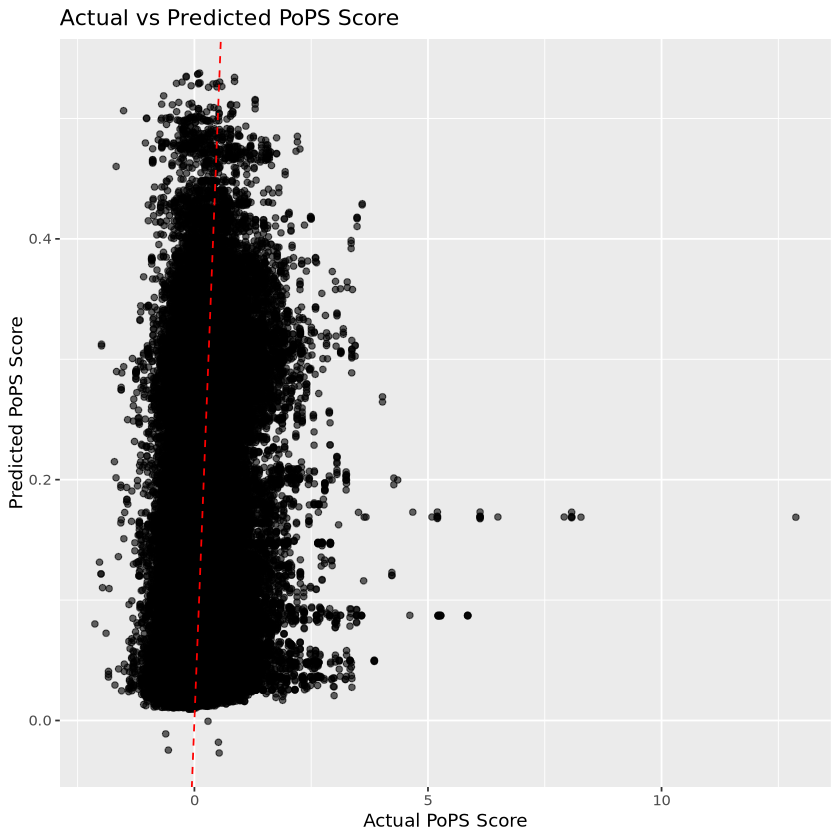

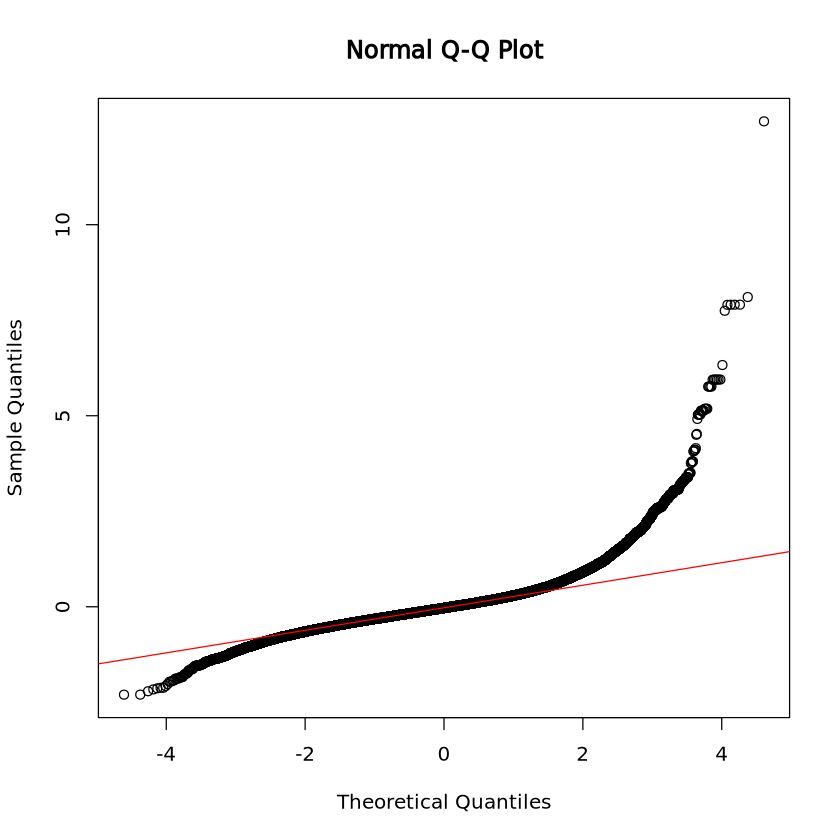

In [3]:
# Train linear model
linear_model <- lm(pops_score ~ pli + cts + dist, data = gwas_pops1)
summary(linear_model)

scores_df <- data.frame(
    pops_score = gwas_pops1$pops_score,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
)
ggplot(scores_df, aes(x = pops_score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted PoPS Score",
    x = "Actual PoPS Score",
    y = "Predicted PoPS Score"
  )

qqnorm(linear_model$residuals) 
qqline(linear_model$residuals, col = "red")



Call:
lm(formula = pops_score ~ pli + scale(cts) + scale(dist), data = gwas_pops1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3008 -0.2246 -0.0317  0.1733 12.7055 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0637947  0.0009385  67.976  < 2e-16 ***
pli         0.2364410  0.0019627 120.466  < 2e-16 ***
scale(cts)  0.0401575  0.0007810  51.420  < 2e-16 ***
scale(dist) 0.0056957  0.0007791   7.311 2.66e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3871 on 246880 degrees of freedom
Multiple R-squared:  0.06868,	Adjusted R-squared:  0.06867 
F-statistic:  6069 on 3 and 246880 DF,  p-value: < 2.2e-16


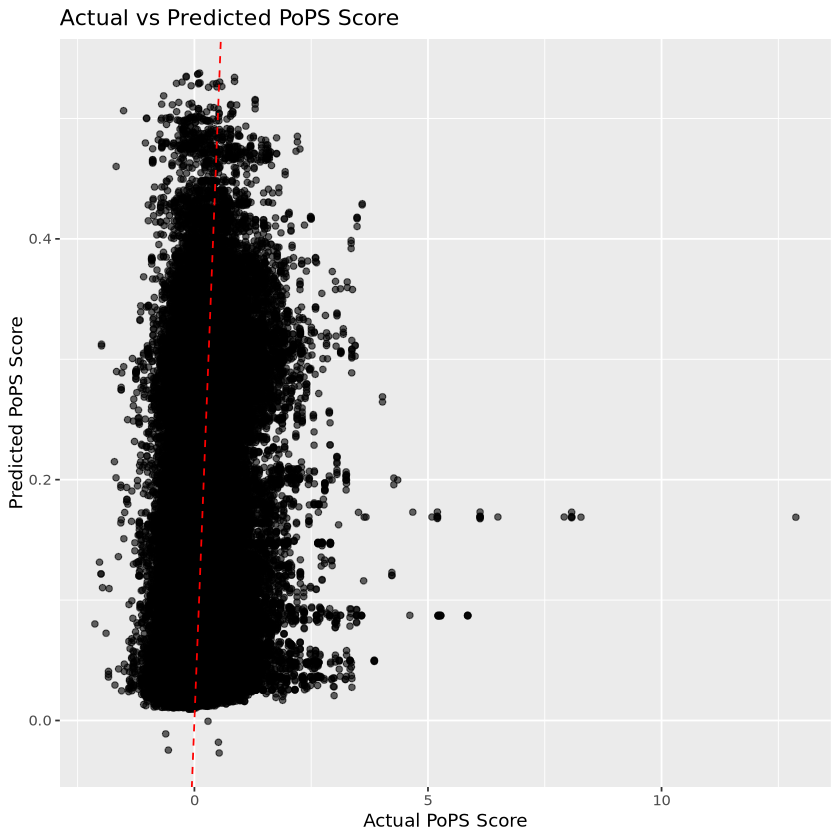

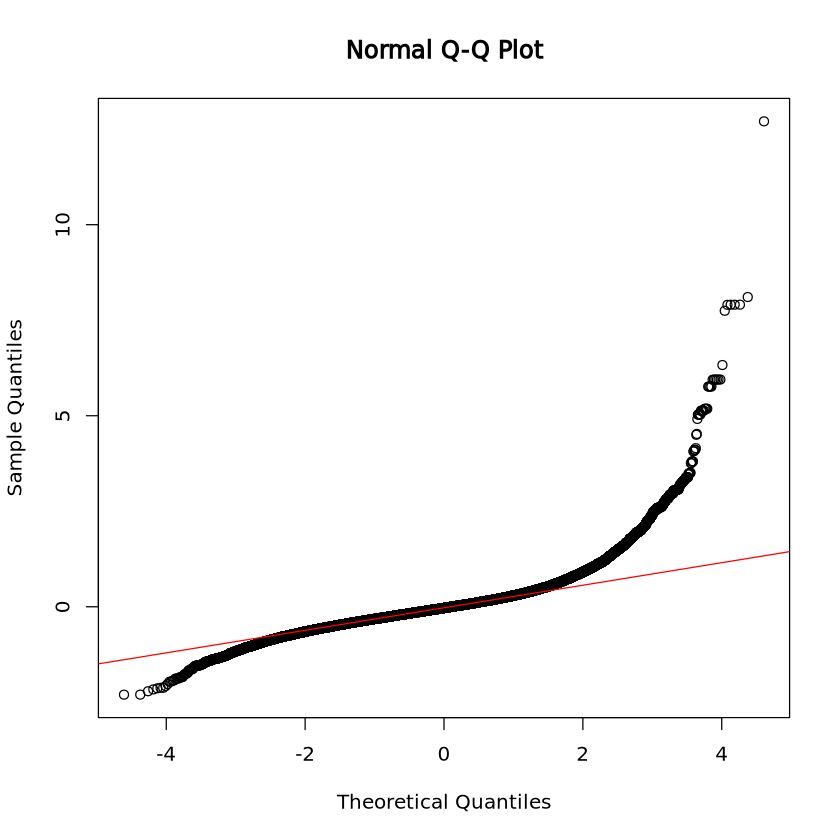

In [23]:
# Train linear model
linear_model <- lm(pops_score ~ pli + scale(cts) + scale(dist), data = gwas_pops1)
summary(linear_model)

scores_df <- data.frame(
    pops_score = gwas_pops1$pops_score,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
)
ggplot(scores_df, aes(x = pops_score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted PoPS Score",
    x = "Actual PoPS Score",
    y = "Predicted PoPS Score"
  )

qqnorm(linear_model$residuals) 
qqline(linear_model$residuals, col = "red")



Call:
lm(formula = pops_score ~ pli + cts + dist + trait, data = gwas_pops1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3675 -0.2190 -0.0234  0.1762 12.7231 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -2.156e-02  2.028e-02  -1.063 0.287743    
pli                          2.376e-01  1.952e-03 121.738  < 2e-16 ***
cts                          5.474e-03  1.061e-04  51.584  < 2e-16 ***
dist                         1.876e-08  2.506e-09   7.487 7.05e-14 ***
traitAG                      5.033e-02  2.088e-02   2.411 0.015928 *  
traitAge_at_Menarche        -1.891e-02  2.234e-02  -0.847 0.397242    
traitAge_at_Menopause       -1.250e-02  2.332e-02  -0.536 0.591806    
traitAID_Combined            4.355e-03  2.739e-02   0.159 0.873662    
traitAlb                     4.094e-03  2.123e-02   0.193 0.847071    
traitALP                     5.669e-02  2.084e-02   2.720 0.006526 ** 
traitALT                    -1.1

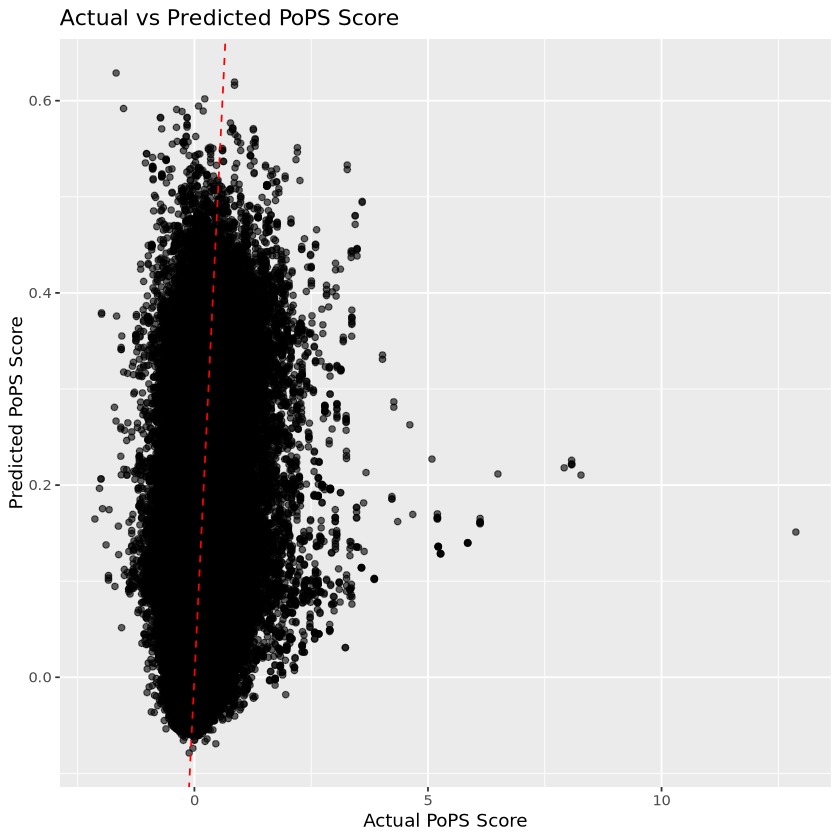

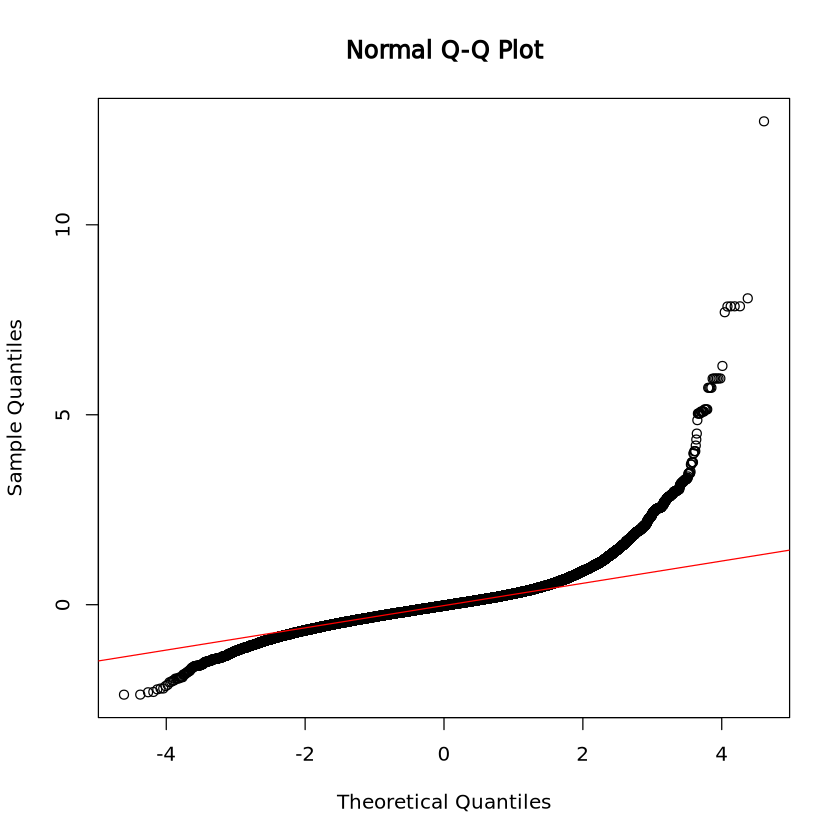

In [4]:
# Train linear model
linear_model <- lm(pops_score ~ pli + cts + dist + trait, data = gwas_pops1)
summary(linear_model)

scores_df <- data.frame(
    pops_score = gwas_pops1$pops_score,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
)
ggplot(scores_df, aes(x = pops_score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted PoPS Score",
    x = "Actual PoPS Score",
    y = "Predicted PoPS Score"
  )

qqnorm(linear_model$residuals) 
qqline(linear_model$residuals, col = "red")



Call:
lm(formula = pops_score ~ pli + cts + dist + eqtl + multiome, 
    data = gwas_pops1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2945 -0.2244 -0.0325  0.1727 12.7140 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.650e-04  1.435e-03  -0.254    0.799    
pli          2.387e-01  1.962e-03 121.677  < 2e-16 ***
cts          5.471e-03  1.065e-04  51.348  < 2e-16 ***
dist         1.842e-08  2.517e-09   7.320 2.48e-13 ***
eqtl         6.164e-02  2.315e-03  26.629  < 2e-16 ***
multiome    -5.077e-03  2.412e-02  -0.210    0.833    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3865 on 246878 degrees of freedom
Multiple R-squared:  0.07135,	Adjusted R-squared:  0.07133 
F-statistic:  3794 on 5 and 246878 DF,  p-value: < 2.2e-16


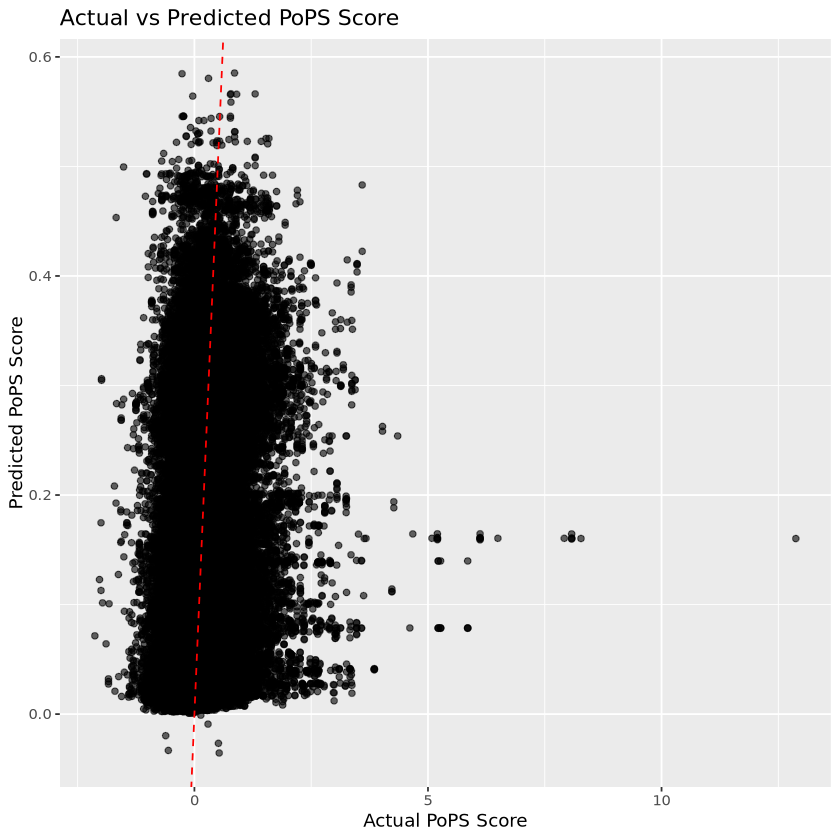

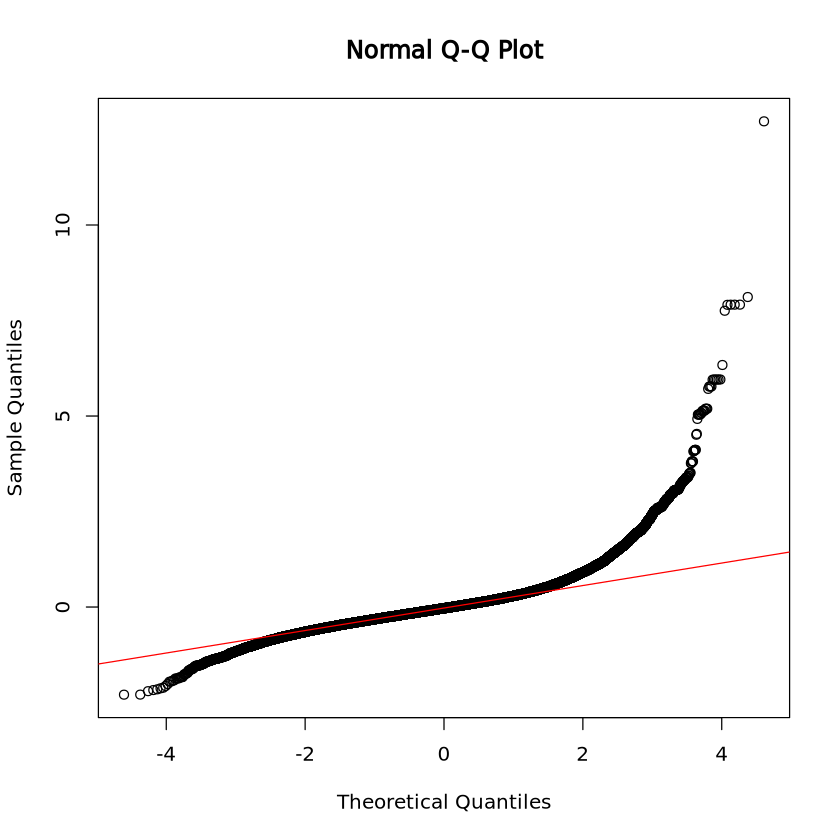

In [5]:
linear_model <- lm(pops_score ~ pli + cts + dist + eqtl + multiome, data = gwas_pops1)
summary(linear_model)

scores_df <- data.frame(
    pops_score = gwas_pops1$pops_score,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
)
ggplot(scores_df, aes(x = pops_score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted PoPS Score",
    x = "Actual PoPS Score",
    y = "Predicted PoPS Score"
  )

qqnorm(linear_model$residuals) 
qqline(linear_model$residuals, col = "red")


### Logistic regression (doesn't really make sense for PoPS score)


Call:
glm(formula = as.factor(pops_priority) ~ pli + cts + dist + eqtl + 
    multiome, family = binomial, data = gwas_pops1)

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -3.218e+00  1.424e-02 -226.052   <2e-16 ***
pli          1.347e+00  1.539e-02   87.523   <2e-16 ***
cts          4.443e-02  7.853e-04   56.578   <2e-16 ***
dist         2.493e-07  2.204e-08   11.311   <2e-16 ***
eqtl         1.741e-01  2.008e-02    8.672   <2e-16 ***
multiome    -7.752e-02  2.205e-01   -0.352    0.725    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 159902  on 246883  degrees of freedom
Residual deviance: 148931  on 246878  degrees of freedom
AIC: 148943

Number of Fisher Scoring iterations: 5


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.6957758 


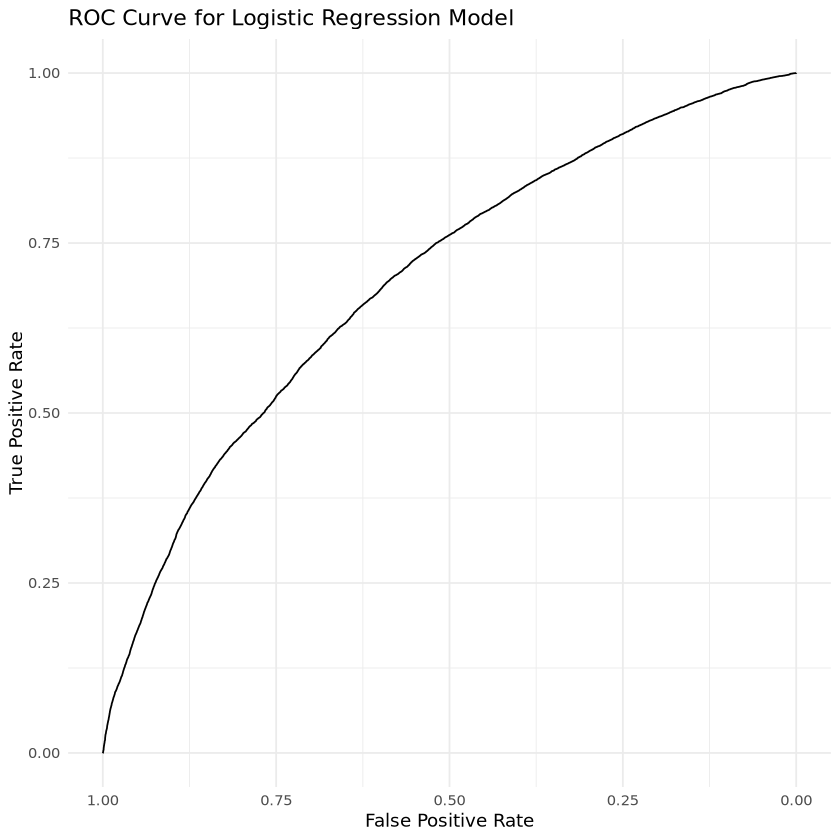

In [6]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(pops_priority) ~ pli + cts + dist + eqtl + multiome,# + multiome_finemap + credible_set, 
                      data = gwas_pops1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(gwas_pops1$pops_priority, logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()


## Estimation for eqtl

### Linear regression


Call:
lm(formula = pip ~ pli + cts + dist, data = eqtl_gtex_susie1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.02261 -0.02124 -0.01710 -0.00911  0.98044 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.179e-02  3.032e-05 718.757  < 2e-16 ***
pli         -1.607e-03  5.058e-05 -31.781  < 2e-16 ***
cts          9.189e-06  2.607e-06   3.525 0.000424 ***
dist         3.891e-10  4.720e-11   8.242  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07972 on 22334277 degrees of freedom
Multiple R-squared:  4.799e-05,	Adjusted R-squared:  4.785e-05 
F-statistic: 357.3 on 3 and 22334277 DF,  p-value: < 2.2e-16


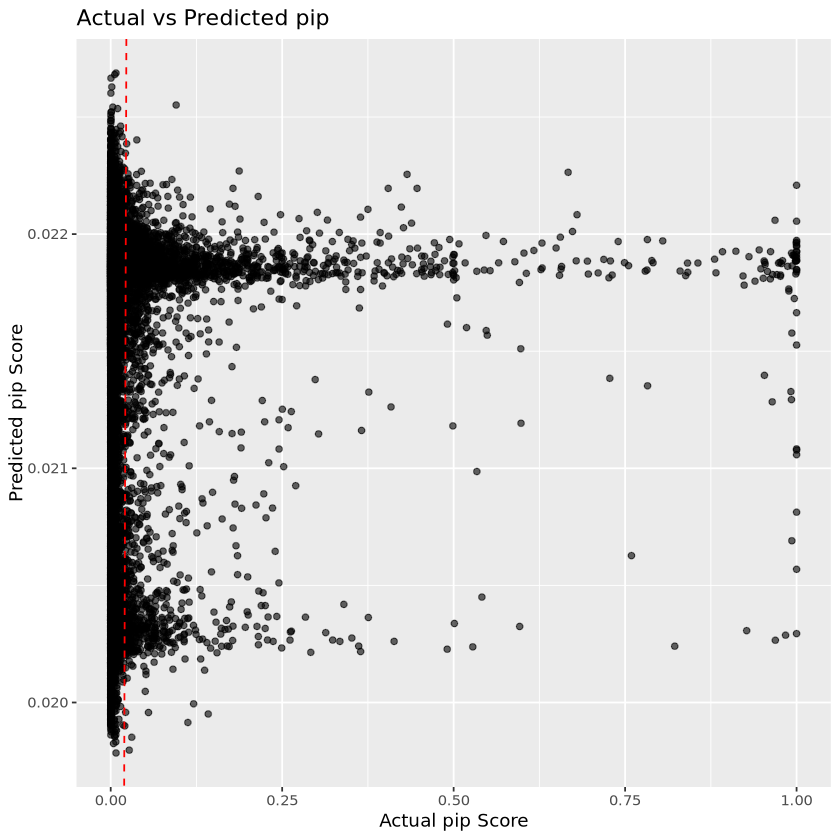

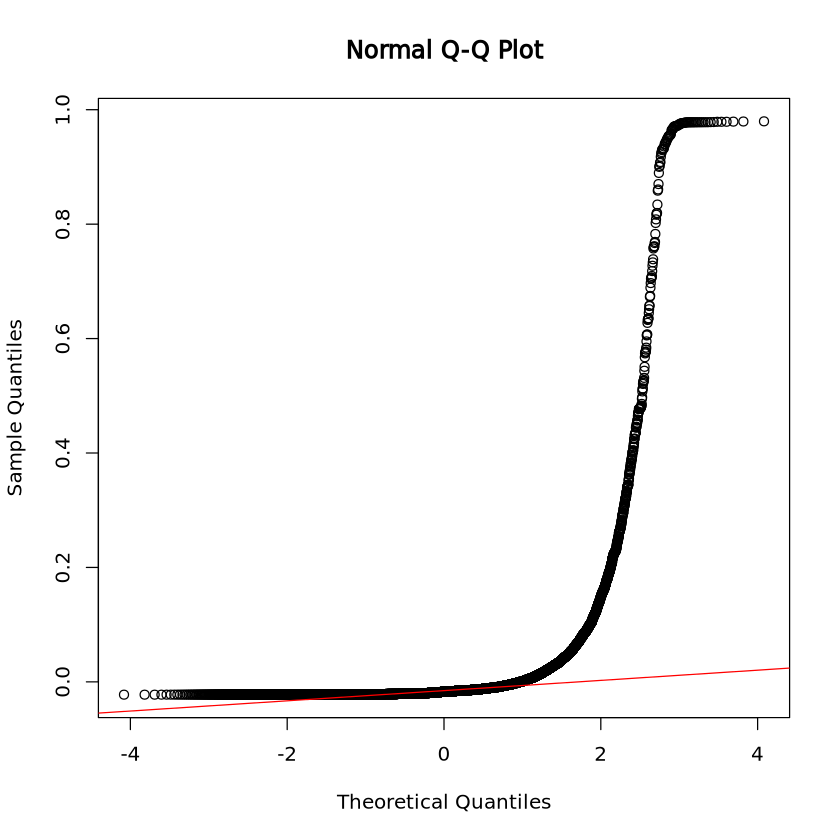

In [3]:
# Train linear model
linear_model <- lm(pip ~ pli + cts + dist, data = eqtl_gtex_susie1)
summary(linear_model)

scores_df <- data.frame(
    pip = eqtl_gtex_susie1$pip,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.001)
ggplot(scores_df, aes(x = pip, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted pip",
    x = "Actual pip Score",
    y = "Predicted pip Score"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")


In [25]:
# # GLM for logit
# linear_model <- glm(pip ~ pli + cts + dist, data = eqtl_gtex_susie1, family = binomial(link = "logit"))
# summary(linear_model)

# scores_df <- data.frame(
#     pip = eqtl_gtex_susie1$pip,
#     fitted_values = linear_model$fitted.values,
#     residuals = linear_model$residuals
# ) %>% 
#     dplyr::sample_frac(0.001)
# ggplot(scores_df, aes(x = pip, y = fitted_values)) +
#   geom_point(alpha = 0.6) +
#   geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
#   labs(
#     title = "Actual vs Predicted pip",
#     x = "Actual pip Score",
#     y = "Predicted pip Score"
#   )

# qqnorm(scores_df$residuals) 
# qqline(scores_df$residuals, col = "red")
sampled <- eqtl_gtex_susie1 %>% dplyr::sample_frac(0.001)
print(dim(sampled))
beta_model <- betareg(pip ~ pli + cts + dist, data = sampled)
summary(beta_model)

scores_df <- data.frame(
    pip = sampled$pip,
    fitted_values = beta_model$fitted.values,
    residuals = beta_model$residuals
) %>% 
    dplyr::sample_frac(0.1)
ggplot(scores_df, aes(x = pip, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted pip",
    x = "Actual pip Score",
    y = "Predicted pip Score"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")


[1] 223343     16



Call:
lm(formula = pip ~ pli + cts + dist + tissue, data = eqtl_gtex_susie1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.03009 -0.02087 -0.01722 -0.00906  0.98469 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                  2.158e-02  8.828e-05 244.449
pli                                         -1.652e-03  5.075e-05 -32.555
cts                                          6.986e-06  2.610e-06   2.677
dist                                         3.719e-10  4.721e-11   7.877
tissueAdipose_Visceral_Omentum               5.910e-04  1.329e-04   4.448
tissueAdrenal_Gland                          5.419e-04  1.673e-04   3.238
tissueArtery_Aorta                           1.272e-03  1.295e-04   9.826
tissueArtery_Coronary                       -3.156e-04  1.900e-04  -1.661
tissueArtery_Tibial                          7.911e-04  1.175e-04   6.732
tissueBrain_Amygdala                        -3.447e-05  2.756e-

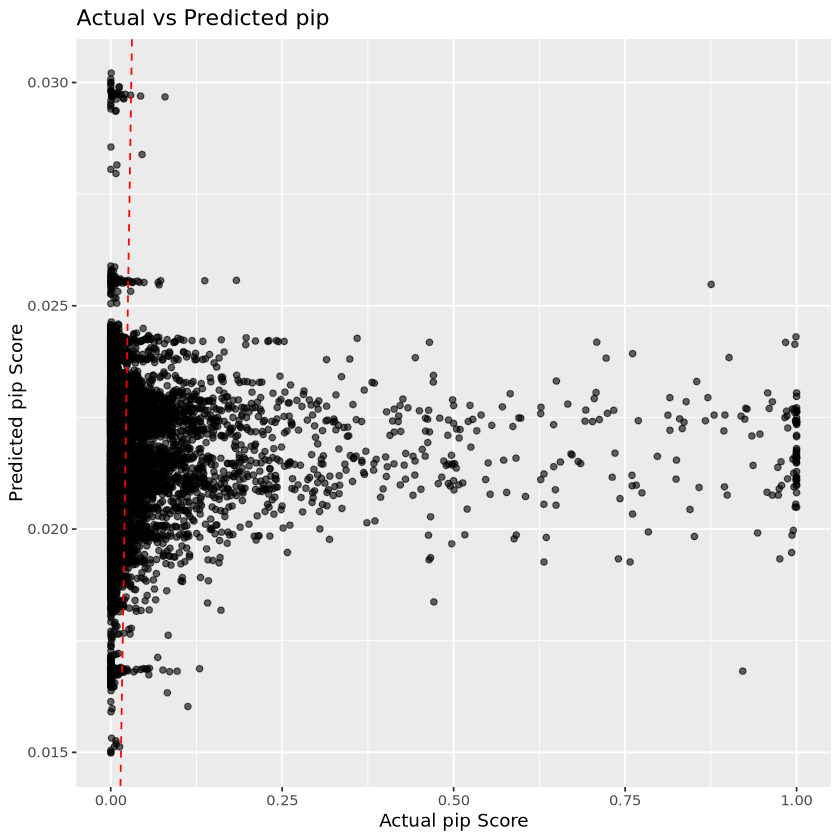

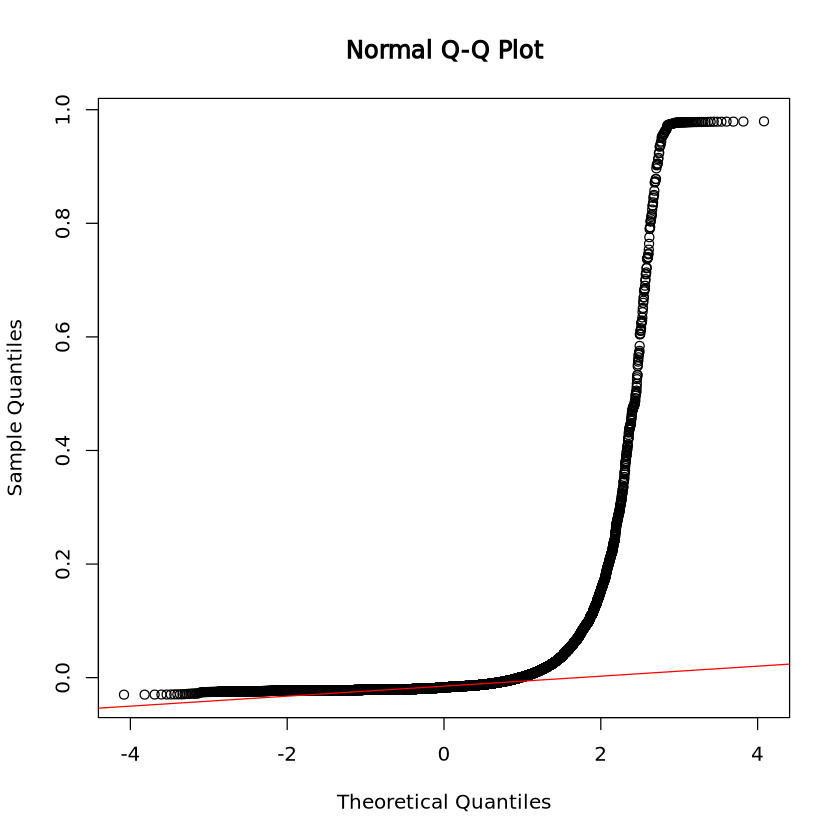

In [4]:
# Train linear model
linear_model <- lm(pip ~ pli + cts + dist + tissue, data = eqtl_gtex_susie1)
summary(linear_model)

scores_df <- data.frame(
    pip = eqtl_gtex_susie1$pip,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.001)
ggplot(scores_df, aes(x = pip, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted pip",
    x = "Actual pip Score",
    y = "Predicted pip Score"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")



Call:
lm(formula = pip ~ pli + cts + dist + tissue + gwas + multiome, 
    data = eqtl_gtex_susie1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08455 -0.02067 -0.01704 -0.00890  0.98496 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                  2.139e-02  8.821e-05 242.540
pli                                         -1.736e-03  5.070e-05 -34.241
cts                                          2.416e-06  2.608e-06   0.926
dist                                         3.692e-10  4.716e-11   7.828
tissueAdipose_Visceral_Omentum               5.984e-04  1.327e-04   4.508
tissueAdrenal_Gland                          5.457e-04  1.672e-04   3.264
tissueArtery_Aorta                           1.280e-03  1.293e-04   9.896
tissueArtery_Coronary                       -2.954e-04  1.898e-04  -1.557
tissueArtery_Tibial                          8.114e-04  1.174e-04   6.911
tissueBrain_Amygdala                    

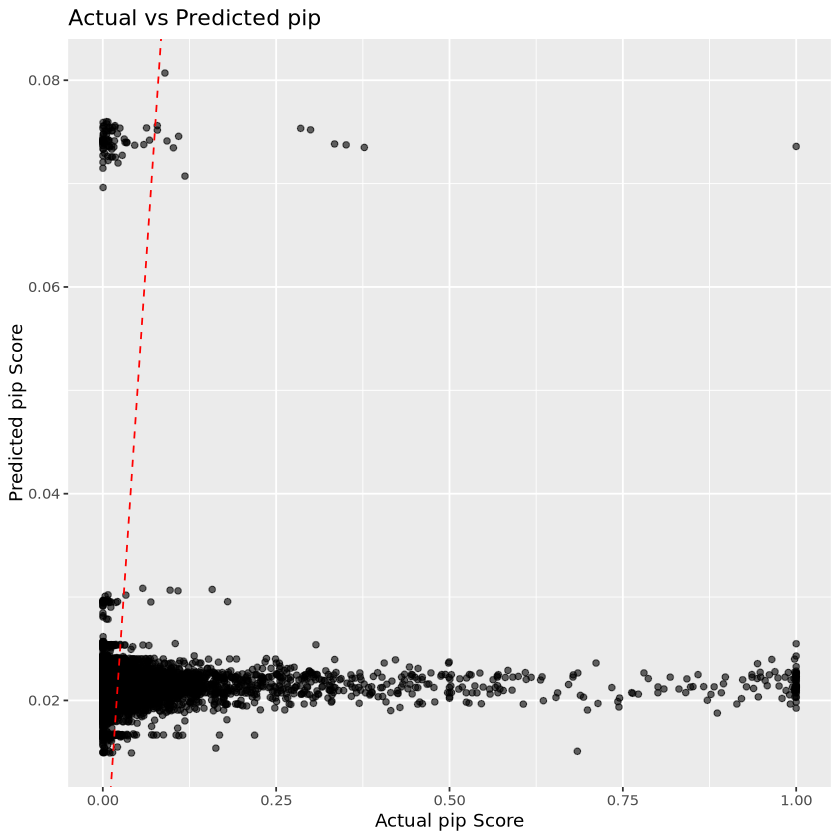

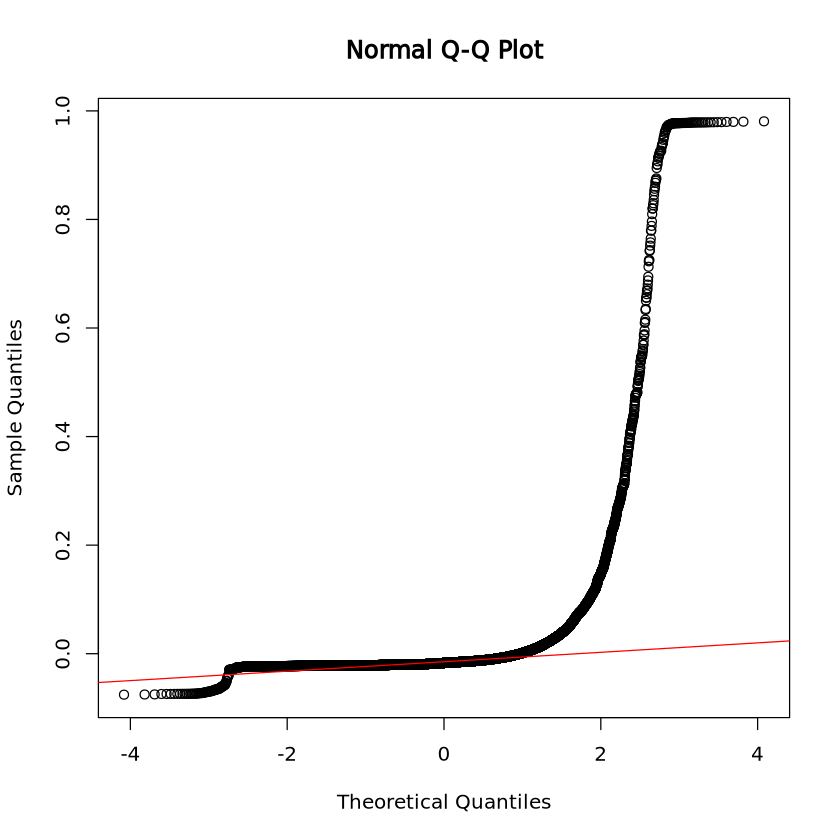

In [5]:
# Train linear model
linear_model <- lm(pip ~ pli + cts + dist + tissue + gwas + multiome, data = eqtl_gtex_susie1)
summary(linear_model)

scores_df <- data.frame(
    pip = eqtl_gtex_susie1$pip,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.001)
ggplot(scores_df, aes(x = pip, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted pip",
    x = "Actual pip Score",
    y = "Predicted pip Score"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")



Call:
lm(formula = pip ~ pli + cts + dist + tissue + gwas + multiome + 
    multiome_finemap + pops_priority, data = eqtl_gtex_susie1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.12717 -0.02067 -0.01704 -0.00890  0.98498 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                  2.141e-02  8.820e-05 242.800
pli                                         -1.778e-03  5.070e-05 -35.071
cts                                          8.970e-07  2.608e-06   0.344
dist                                         3.662e-10  4.716e-11   7.766
tissueAdipose_Visceral_Omentum               5.975e-04  1.327e-04   4.502
tissueAdrenal_Gland                          5.455e-04  1.672e-04   3.263
tissueArtery_Aorta                           1.279e-03  1.293e-04   9.885
tissueArtery_Coronary                       -2.943e-04  1.898e-04  -1.551
tissueArtery_Tibial                          8.113e-04  1.174e-04   6.911
tissu

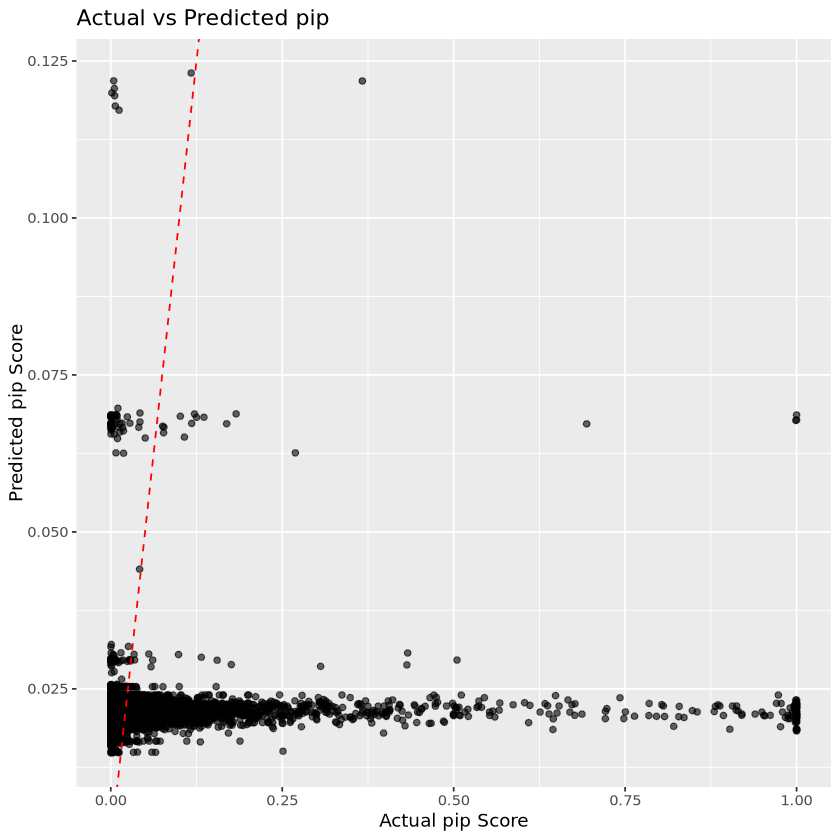

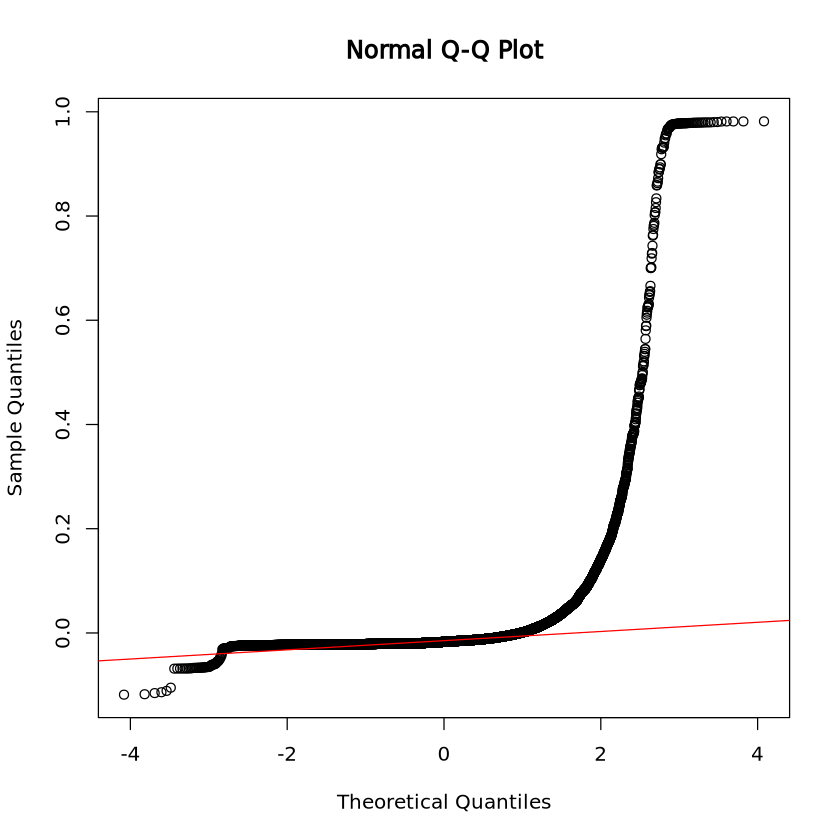

In [6]:
# Train linear model
linear_model <- lm(pip ~ pli + cts + dist + tissue + gwas + multiome + multiome_finemap + pops_priority, 
                   data = eqtl_gtex_susie1)
summary(linear_model)

scores_df <- data.frame(
    pip = eqtl_gtex_susie1$pip,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.001)
ggplot(scores_df, aes(x = pip, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted pip",
    x = "Actual pip Score",
    y = "Predicted pip Score"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")


### Logistic regression


Call:
glm(formula = as.factor(max_pip) ~ scale(pli) + scale(cts) + 
    scale(dist) + multiome + gwas + multiome_finemap + pops_priority, 
    family = binomial, data = eqtl_gtex_susie1)

Coefficients:
                  Estimate Std. Error   z value Pr(>|z|)    
(Intercept)      -5.935005   0.004137 -1434.628  < 2e-16 ***
scale(pli)       -0.043231   0.004220   -10.244  < 2e-16 ***
scale(cts)        0.014849   0.004006     3.706  0.00021 ***
scale(dist)       0.019672   0.004114     4.781 1.74e-06 ***
multiome          0.247399   0.128460     1.926  0.05412 .  
gwas              1.887544   0.027335    69.052  < 2e-16 ***
multiome_finemap  0.228882   1.012084     0.226  0.82109    
pops_priority     0.829555   0.054575    15.200  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 837454  on 22334280  degrees of freedom
Residual deviance: 832857  on 22334273  degrees of freedom
AIC:

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.5249584 


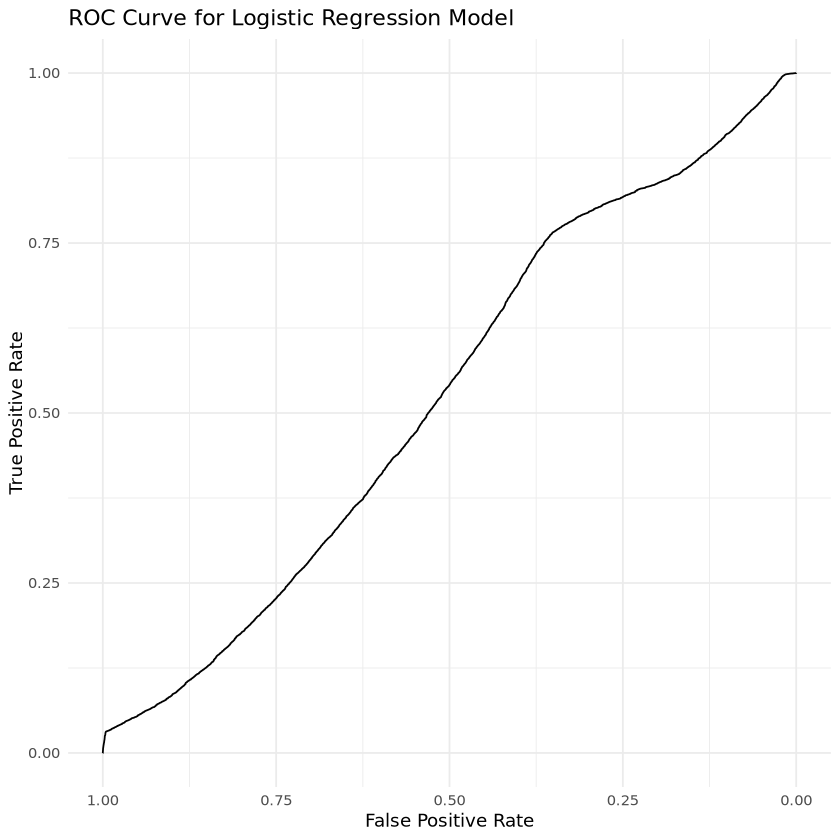

In [11]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(max_pip) ~ scale(pli) + scale(cts) + scale(dist) + multiome +gwas + multiome_finemap + pops_priority,# + tissue, 
                      data = eqtl_gtex_susie1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(eqtl_gtex_susie1$max_pip, logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()


In [8]:
eqtl_gtex_susie1$max_pip %>% table()

.
       0        1 
22273666    60615 


Call:
glm(formula = as.factor(credible_set) ~ pli + cts + dist + multiome + 
    gwas + multiome_finemap + pops_priority, family = binomial, 
    data = eqtl_gtex_susie1)

Coefficients:
                   Estimate Std. Error   z value Pr(>|z|)    
(Intercept)      -3.006e+00  1.817e-03 -1654.122   <2e-16 ***
pli               2.323e-01  2.825e-03    82.233   <2e-16 ***
cts              -4.908e-03  1.587e-04   -30.921   <2e-16 ***
dist              3.120e-08  2.791e-09    11.181   <2e-16 ***
multiome          2.316e-01  3.293e-02     7.034    2e-12 ***
gwas              5.293e-01  1.317e-02    40.186   <2e-16 ***
multiome_finemap  7.191e-02  2.887e-01     0.249    0.803    
pops_priority     5.478e-01  2.987e-02    18.338   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8494565  on 22334280  degrees of freedom
Residual deviance: 8484539  on 22334273  degrees of freedom
AIC: 8484

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.5230499 


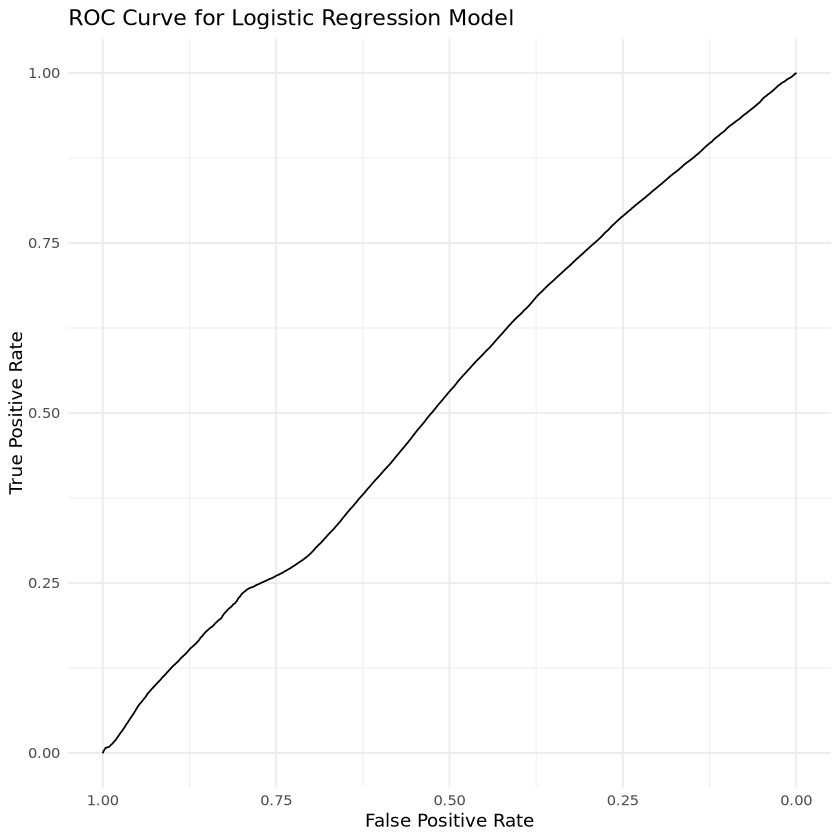

In [10]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(credible_set) ~ pli + cts + dist + multiome +gwas + multiome_finemap + pops_priority,
                      data = eqtl_gtex_susie1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(as.factor(eqtl_gtex_susie1$credible_set), logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()


## Estimation for multiome

### Linear regression


Call:
lm(formula = SCENT ~ pli + cts + dist, data = multiome_pgb1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95262  0.04447  0.05986  0.08903  0.29433 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.654e-01  1.803e-04 5353.46   <2e-16 ***
pli         -3.888e-02  2.514e-04 -154.63   <2e-16 ***
cts         -3.498e-03  1.326e-05 -263.91   <2e-16 ***
dist        -2.518e-10  6.518e-12  -38.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1948 on 3893160 degrees of freedom
Multiple R-squared:  0.02454,	Adjusted R-squared:  0.02454 
F-statistic: 3.265e+04 on 3 and 3893160 DF,  p-value: < 2.2e-16


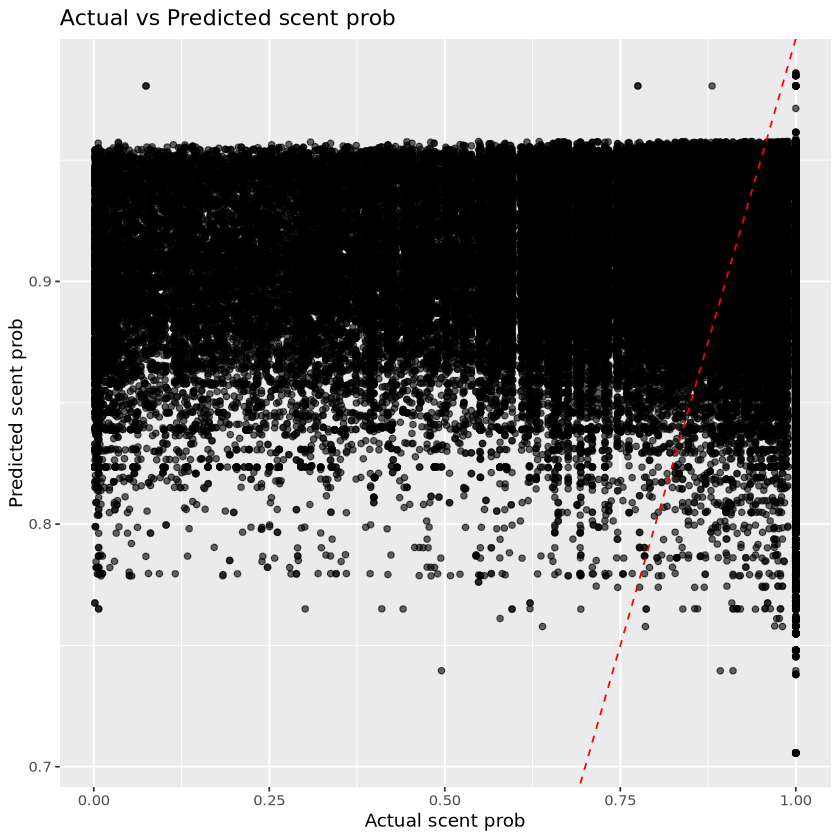

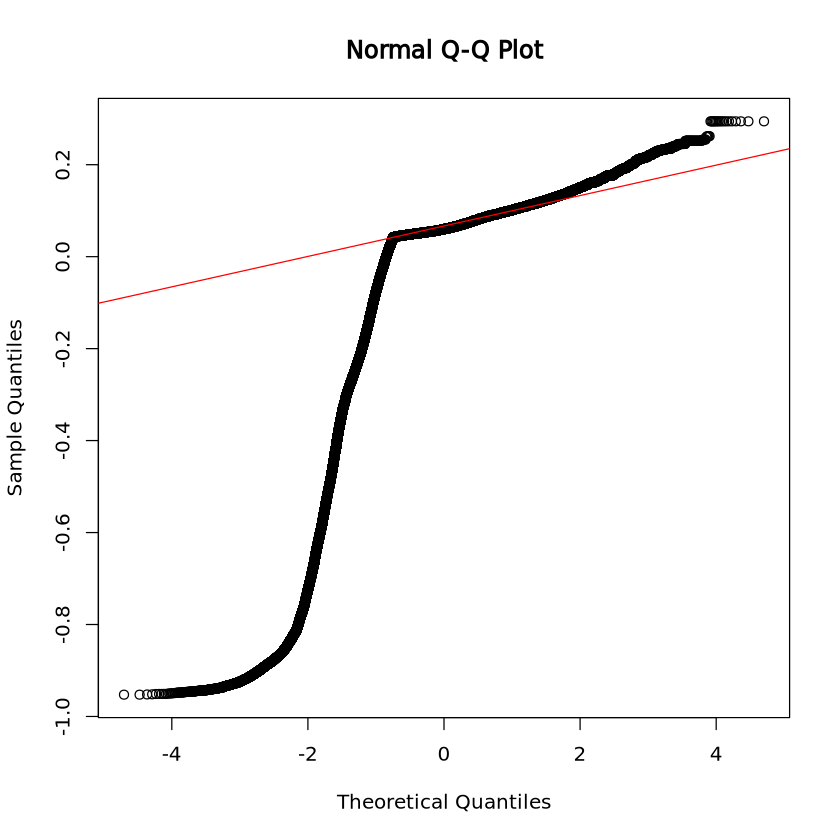

In [4]:
# Train linear model
# sampled <- multiome_pgb1 %>% 
#     dplyr::sample_frac(0.001)
# linear_model <- betareg(SCENT ~ pli + cts + dist, data = sampled)
linear_model <- lm(SCENT ~ pli + cts + dist, data = multiome_pgb1)
summary(linear_model)

scores_df <- data.frame(
    score = multiome_pgb1$SCENT,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.1)
ggplot(scores_df, aes(x = score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted scent prob",
    x = "Actual scent prob",
    y = "Predicted scent prob"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")



Call:
lm(formula = SCENT ~ pli + cts + dist + gwas + eqtl, data = multiome_pgb1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95265  0.04444  0.05987  0.08903  0.29438 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  9.655e-01  1.804e-04 5351.760  < 2e-16 ***
pli         -3.889e-02  2.514e-04 -154.676  < 2e-16 ***
cts         -3.498e-03  1.326e-05 -263.920  < 2e-16 ***
dist        -2.521e-10  6.519e-12  -38.678  < 2e-16 ***
gwas         3.159e-02  1.238e-02    2.552   0.0107 *  
eqtl        -1.672e-02  2.590e-03   -6.458 1.06e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1948 on 3893158 degrees of freedom
Multiple R-squared:  0.02456,	Adjusted R-squared:  0.02455 
F-statistic: 1.96e+04 on 5 and 3893158 DF,  p-value: < 2.2e-16


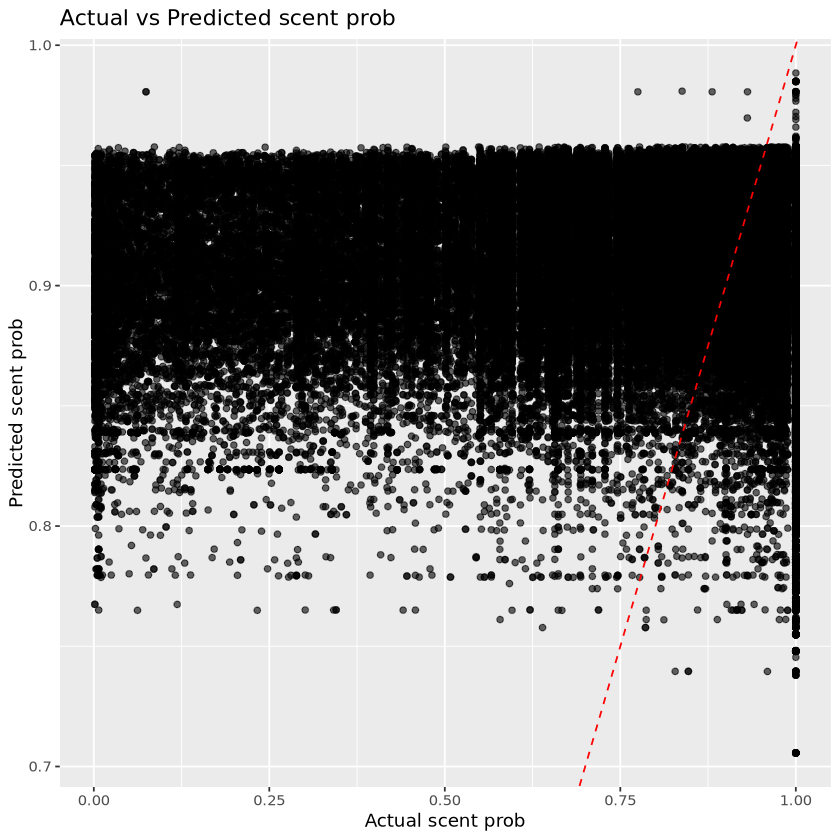

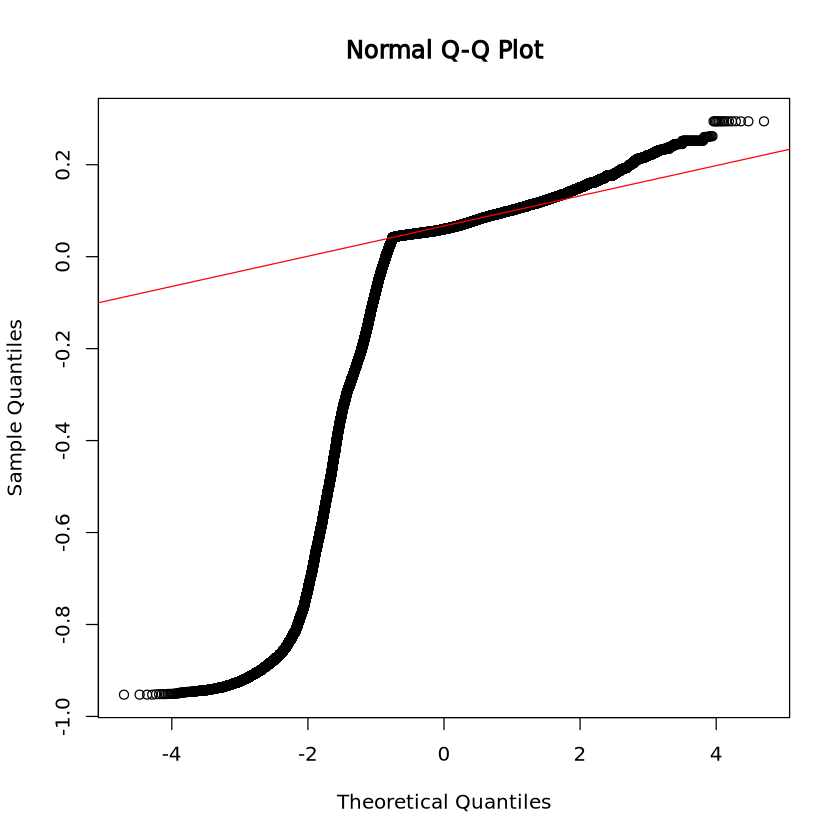

In [5]:
# Train linear model
# sampled <- multiome_pgb1 %>% 
#     dplyr::sample_frac(0.001)
# linear_model <- betareg(SCENT ~ pli + cts + dist, data = sampled)
linear_model <- lm(SCENT ~ pli + cts + dist + gwas + eqtl, data = multiome_pgb1)
summary(linear_model)

scores_df <- data.frame(
    score = multiome_pgb1$SCENT,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.1)
ggplot(scores_df, aes(x = score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted scent prob",
    x = "Actual scent prob",
    y = "Predicted scent prob"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")


Loading required namespace: numDeriv

Warning message in sqrt(diag(object$vcov)):
“NaNs produced”



Call:
betareg(formula = SCENT ~ pli + cts + dist, data = sampled)

Randomized quantile residuals:
     Min       1Q   Median       3Q      Max 
-22.9537  -7.0781  -0.4291   0.4332   4.0777 

Coefficients (mu model with logit link):
              Estimate Std. Error z value Pr(>|z|)
(Intercept)  9.632e+00        NaN     NaN      NaN
pli         -9.574e-01        NaN     NaN      NaN
cts         -6.770e-02        NaN     NaN      NaN
dist        -7.357e-09  1.198e-06  -0.006    0.995

Phi coefficients (phi model with identity link):
      Estimate Std. Error z value Pr(>|z|)
(phi)    333.8        NaN     NaN      NaN

Exceedence parameter (extended-support xbetax model):
          Estimate Std. Error z value Pr(>|z|)    
Log(nu) -0.2914564  0.0005746  -507.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Exceedence parameter nu: 0.7472
Type of estimator: ML (maximum likelihood)
Log-likelihood: -1.25e+06 on 6 Df
Number of iterations in BFGS optimization

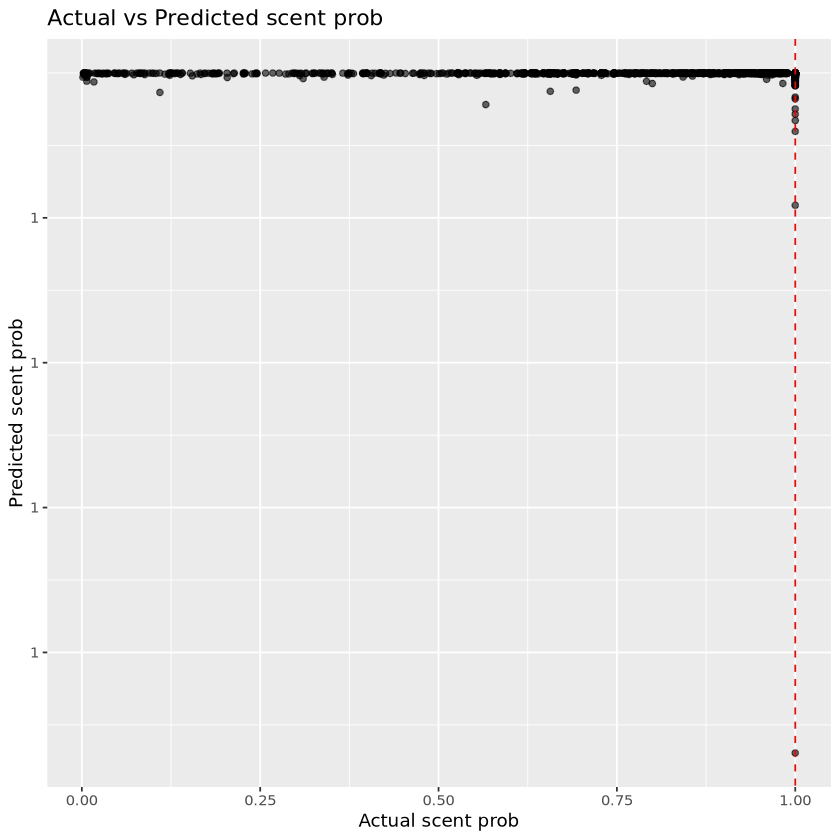

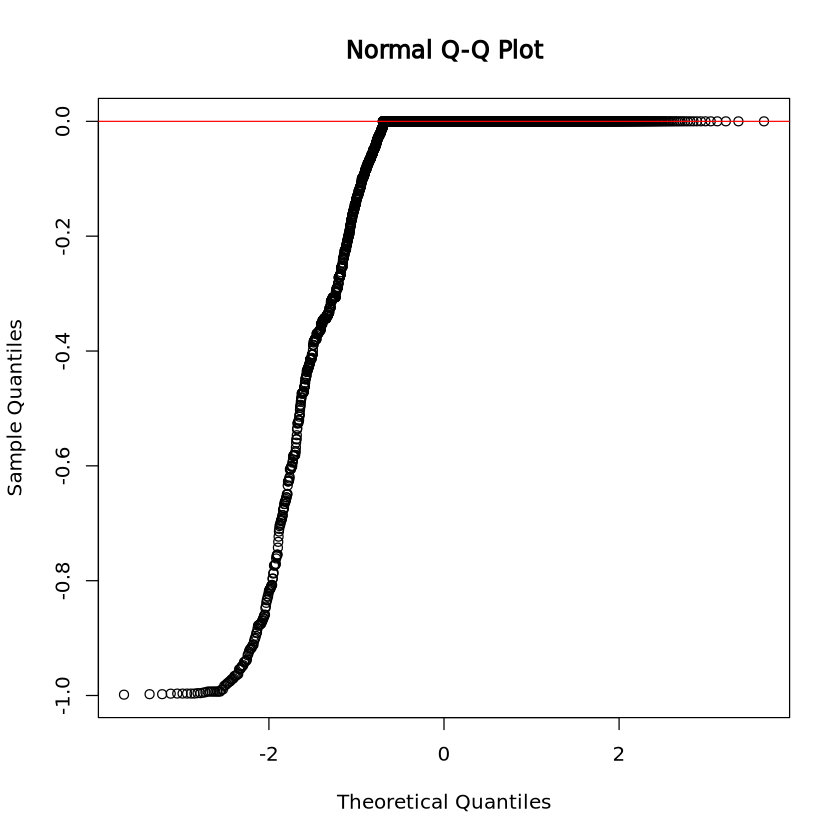

In [12]:
# Train linear model
sampled <- multiome_pgb1 %>% 
    dplyr::sample_frac(0.01)
linear_model <- betareg(SCENT ~ pli + cts + dist, data = sampled)
# linear_model <- lm(SCENT ~ pli + cts + dist + gwas + eqtl, data = multiome_pgb1)
summary(linear_model)

scores_df <- data.frame(
    score = sampled$SCENT,
    fitted_values = linear_model$fitted.values,
    residuals = linear_model$residuals
) %>% 
    dplyr::sample_frac(0.1)
ggplot(scores_df, aes(x = score, y = fitted_values)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(
    title = "Actual vs Predicted scent prob",
    x = "Actual scent prob",
    y = "Predicted scent prob"
  )

qqnorm(scores_df$residuals) 
qqline(scores_df$residuals, col = "red")


### Logistic regression


Call:
glm(formula = as.factor(multiome_finemap) ~ pli + cts + dist, 
    family = binomial, data = multiome_pgb1)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.585e+00  9.332e-03 -598.46   <2e-16 ***
pli          5.212e-01  1.129e-02   46.15   <2e-16 ***
cts          7.237e-02  4.017e-04  180.16   <2e-16 ***
dist         6.947e-09  2.167e-10   32.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 489206  on 3893163  degrees of freedom
Residual deviance: 461491  on 3893160  degrees of freedom
AIC: 461499

Number of Fisher Scoring iterations: 7


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.7240568 


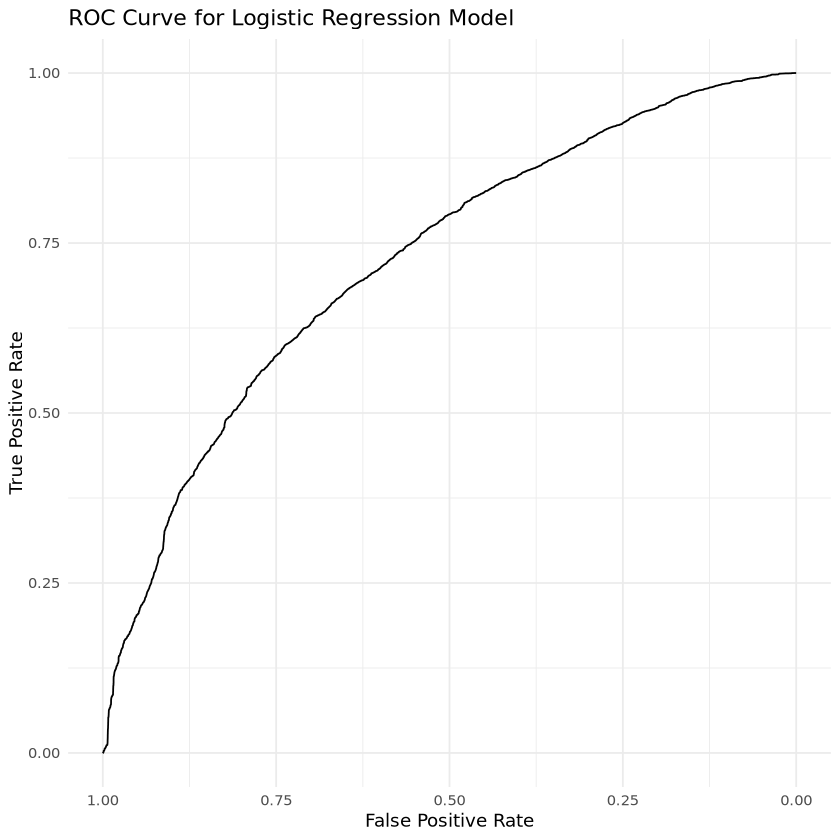

In [12]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(multiome_finemap) ~ pli + cts + dist, # + eqtl + multiome,# + multiome_finemap + credible_set, 
                      data = multiome_pgb1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(multiome_pgb1$multiome_finemap, logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()



Call:
glm(formula = as.factor(multiome_finemap) ~ pli + cts + dist + 
    eqtl + gwas, family = binomial, data = multiome_pgb1)

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -5.585e+00  9.335e-03 -598.294   <2e-16 ***
pli          5.214e-01  1.129e-02   46.161   <2e-16 ***
cts          7.237e-02  4.017e-04  180.169   <2e-16 ***
dist         6.952e-09  2.166e-10   32.089   <2e-16 ***
eqtl         2.567e-01  1.175e-01    2.184    0.029 *  
gwas        -2.702e-01  7.126e-01   -0.379    0.705    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 489206  on 3893163  degrees of freedom
Residual deviance: 461486  on 3893158  degrees of freedom
AIC: 461498

Number of Fisher Scoring iterations: 7


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.7240898 


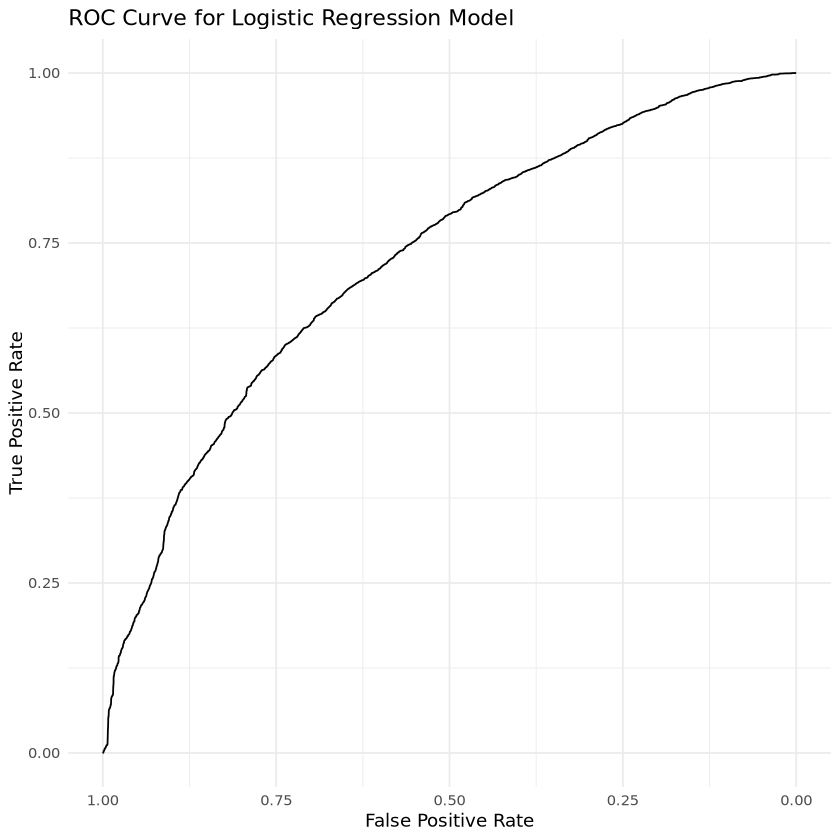

In [13]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(multiome_finemap) ~ pli + cts + dist + eqtl + gwas, #+ pops_priority + credible_set, 
                      data = multiome_pgb1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(multiome_pgb1$multiome_finemap, logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()


Call:
glm(formula = as.factor(multiome_finemap) ~ pli + cts + dist + 
    eqtl + gwas + pops_priority + credible_set, family = binomial, 
    data = multiome_pgb1)

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)   -5.585e+00  9.336e-03 -598.261   <2e-16 ***
pli            5.214e-01  1.129e-02   46.161   <2e-16 ***
cts            7.237e-02  4.017e-04  180.165   <2e-16 ***
dist           6.952e-09  2.166e-10   32.088   <2e-16 ***
eqtl           2.553e-01  1.208e-01    2.114   0.0345 *  
gwas          -1.535e-01  7.133e-01   -0.215   0.8297    
pops_priority -6.048e+00  2.510e+01   -0.241   0.8096    
credible_set   2.306e-02  5.214e-01    0.044   0.9647    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 489206  on 3893163  degrees of freedom
Residual deviance: 461486  on 3893156  degrees of freedom
AIC: 461502

Number of Fisher Scoring iterations: 9


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.7240905 


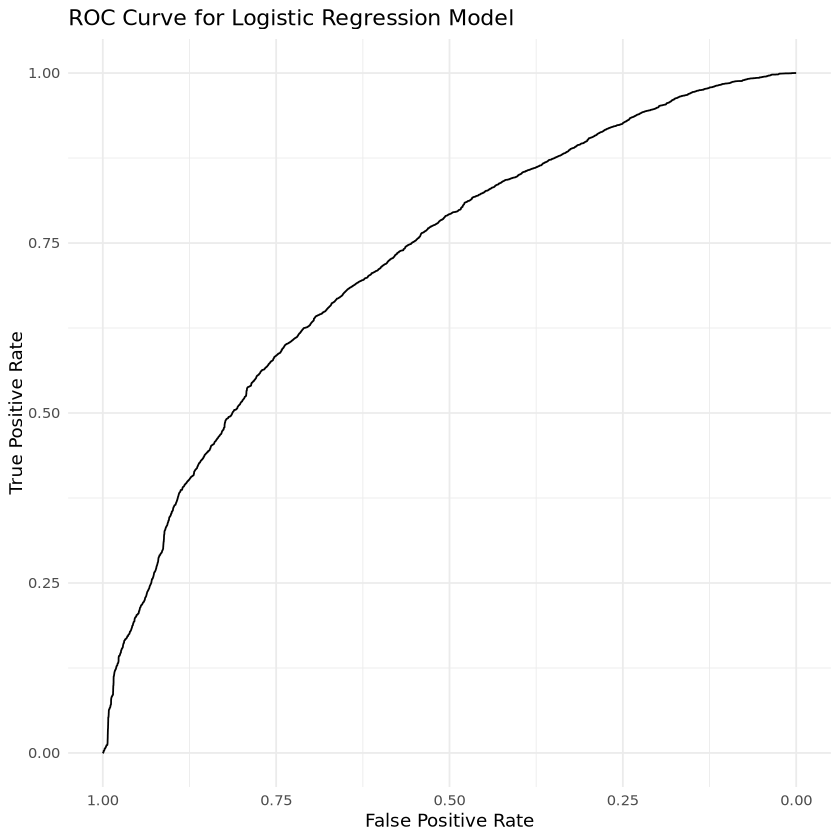

In [14]:
# Fit the logistic regression model
logistic_model <- glm(as.factor(multiome_finemap) ~ pli + cts + dist + eqtl + gwas + pops_priority + credible_set, 
                      data = multiome_pgb1, 
                      family = binomial)

# View the model summary
summary(logistic_model)

# Create a ROC curve
roc_curve <- roc(multiome_pgb1$multiome_finemap, logistic_model$fitted.values)
auc_value <- auc(roc_curve)

# Print AUC
cat("AUC:", auc_value, "\n")

# Plot the ROC curve
ggroc(roc_curve) +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate",
       y = "True Positive Rate") +
  theme_minimal()

In [15]:
eqtl_gtex_susie1 %>% 
    dplyr::select(pops_priority, credible_set, multiome_finemap) %>% table()

, , multiome_finemap = 0

             credible_set
pops_priority        0        1
            0 21269396  1052430
            1    10650     1601

, , multiome_finemap = 1

             credible_set
pops_priority        0        1
            0      191       13
            1        0        0


In [18]:
multiome_pgb1 %>% 
    dplyr::select(pops_priority, credible_set, multiome_finemap) %>% table()

, , multiome_finemap = 0

             credible_set
pops_priority       0       1
            0 3848053     280
            1      22       0

, , multiome_finemap = 1

             credible_set
pops_priority       0       1
            0   44805       4
            1       0       0


In [19]:
gwas_pops1 %>% 
    dplyr::select(pops_priority, credible_set, multiome_finemap) %>% table()

, , multiome_finemap = 0

             credible_set
pops_priority      0      1
            0 220075   2258
            1  23910    639

, , multiome_finemap = 1

             credible_set
pops_priority      0      1
            0      1      1
            1      0      0


In [20]:
gwas_pops1 %>% 
    dplyr::select(eqtl, multiome) %>% table()

    multiome
eqtl      0      1
   0 214562    210
   1  32065     47

In [21]:
multiome_pgb1 %>% 
    dplyr::select(gwas, eqtl) %>% table()

    eqtl
gwas       0       1
   0 3887286    5630
   1     201      47

In [22]:
eqtl_gtex_susie1 %>% 
    dplyr::select(gwas, multiome) %>% table()

    multiome
gwas        0        1
   0 22224177    16676
   1    93222      206

In [13]:
head(multiome_pgb)

,region,chr,start,gene,pli,cts,dist,SCENT,multiome,multiome_finemap
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:100028377-100028378,chr1,100028377,ENSG00000162688,0.00,7.170039,-175708,1,1,0
2,chr1:100028377-100028378,chr1,100028377,ENSG00000079335,0.00,6.682904,395354,1,1,0
3,chr1:100028377-100028378,chr1,100028377,ENSG00000137992,0.00,7.697298,221442,1,1,0
4,chr1:100028377-100028378,chr1,100028377,ENSG00000156869,0.00,6.088846,-261747,1,1,0
5,chr1:100028377-100028378,chr1,100028377,ENSG00000122477,0.00,3.725788,149837,1,1,0
6,chr1:100028377-100028378,chr1,100028377,ENSG00000156875,0.97,5.316942,30293,1,1,0
